In [1]:
import tensorflow as tf
import tensorflow_federated as tff
import tensorflow_privacy as tfp
import nest_asyncio
nest_asyncio.apply()
import matplotlib.pyplot as plt

In [2]:
# Load the CIFAR-10 dataset
(cifar10_train_images, cifar10_train_labels), (cifar10_test_images, cifar10_test_labels) = tf.keras.datasets.cifar10.load_data()

In [3]:
# Access the first image and its corresponding label from the training dataset
sample_image = cifar10_train_images[0]
sample_label = cifar10_train_labels[0]


In [4]:
sample_image


array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

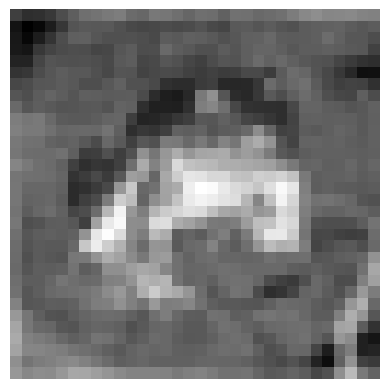

In [5]:
# Access an image from the training dataset (e.g., the first image)
sample_image = cifar10_train_images[0]

# Convert to grayscale
sample_image_gray = sample_image.mean(axis=2)  # Take the mean along the color channels

# Display the grayscale image
plt.imshow(sample_image_gray, cmap='gray')
plt.axis('off')  # Hide axes
plt.show()

In [6]:
sample_label

array([6], dtype=uint8)

In [7]:
# Display information about the sample image
print(f"Sample Image Shape: {sample_image.shape}")
print(f"Sample Label: {sample_label}")

Sample Image Shape: (32, 32, 3)
Sample Label: [6]


In [8]:
# Preprocess the dataset
def preprocess(images, labels):
    images = tf.cast(images, tf.float32) / 255.0
    return (images, labels)

In [9]:
# Split the dataset into multiple "client" datasets
num_clients = 10
client_datasets = []
for i in range(num_clients):
    start = i * len(cifar10_train_images) // num_clients
    end = (i + 1) * len(cifar10_train_images) // num_clients
    client_images = cifar10_train_images[start:end]
    client_labels = cifar10_train_labels[start:end]
    client_dataset = tf.data.Dataset.from_tensor_slices((client_images, client_labels))
    client_dataset = client_dataset.map(preprocess).batch(20)
    client_datasets.append(client_dataset)

### Differential privacy is a mathematical technique that balances data privacy and data utility. It allows organizations to analyze and share private data without revealing sensitive information about individuals. Here’s how it works:

#### Randomization: Differential privacy introduces controlled randomness (noise) into datasets. The goal is to prevent anyone from identifying specific individuals in the dataset.
#### Privacy Budget (ε): Differential privacy uses a privacy loss parameter, often denoted as ε (epsilon). This parameter controls how much noise is added to the raw dataset. A higher ε value means more accurate but less private data.
##### Example Process:
Suppose you have a dataset with a column containing “Yes” or “No” answers from individuals.
For each individual, you flip a coin:
If it’s heads, you keep the answer as is.
If it’s tails, you flip the coin again:
Heads: Record the answer as “Yes.”
Tails: Record the answer as “No.”
This process adds randomness while maintaining aggregate accuracy.

In [10]:
# Define a simple CNN model
def create_keras_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(32, 32, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10)
    ])
    return model



def model_fn_standard():
    keras_model = create_keras_model()
    return tff.learning.from_keras_model(
        keras_model,
        input_spec=client_datasets[0].element_spec,
        #It specifies the input specification based on the first client dataset (client_datasets[0].element_spec).
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

def model_fn_with_dp():
    keras_model = create_keras_model()
    optimizer = tfp.DPAdamGaussianOptimizer(
        l2_norm_clip=1.0,
        noise_multiplier=0.5,
        num_microbatches=1,
        learning_rate=0.001
    )
    keras_model.compile(optimizer=optimizer,
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    return tff.learning.from_keras_model(
        keras_model,
        input_spec=client_datasets[0].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])



#### In  model_fn_with_dp function, I have used the DPAdamGaussianOptimizer from the tensorflow_privacy library. This optimizer adds Gaussian noise to the gradients during the optimization process, which is a common technique for implementing differential privacy in deep learning models.

In [11]:
def assign_weights_to_keras_model(keras_model, tff_state):
    tff_weights = tff_state.model.trainable
    for var, tff_var in zip(keras_model.trainable_variables, tff_weights):
        var.assign(tff_var)  # Removed .numpy()

In [12]:
def evaluate_model(state, model_fn, test_dataset):
    keras_model = create_keras_model()
    assign_weights_to_keras_model(keras_model, state)

    keras_model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

    test_images, test_labels = zip(*list(test_dataset))
    test_images = tf.concat(test_images, axis=0)
    test_labels = tf.concat(test_labels, axis=0)

    loss, accuracy = keras_model.evaluate(test_images, test_labels, verbose=0)
    return loss, accuracy

In [13]:
def check_dataset(dataset):
    for batch in dataset.take(1):
        images, labels = batch
        print(f'Batch shape: {images.shape}, Labels: {labels.numpy()}')

In [14]:
for i, client_dataset in enumerate(client_datasets):
    print(f'Client {i} dataset:')
    check_dataset(client_dataset)

Client 0 dataset:
Batch shape: (20, 32, 32, 3), Labels: [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]
 [4]
 [7]
 [7]
 [2]
 [9]
 [9]
 [9]
 [3]
 [2]
 [6]]
Client 1 dataset:
Batch shape: (20, 32, 32, 3), Labels: [[6]
 [7]
 [9]
 [0]
 [5]
 [2]
 [3]
 [3]
 [3]
 [9]
 [0]
 [9]
 [2]
 [9]
 [1]
 [0]
 [2]
 [3]
 [9]
 [6]]
Client 2 dataset:
Batch shape: (20, 32, 32, 3), Labels: [[1]
 [6]
 [6]
 [8]
 [8]
 [3]
 [4]
 [6]
 [0]
 [6]
 [0]
 [3]
 [6]
 [6]
 [5]
 [4]
 [8]
 [3]
 [2]
 [6]]
Client 3 dataset:
Batch shape: (20, 32, 32, 3), Labels: [[0]
 [6]
 [7]
 [0]
 [4]
 [9]
 [5]
 [8]
 [0]
 [4]
 [3]
 [8]
 [4]
 [7]
 [1]
 [8]
 [3]
 [5]
 [4]
 [5]]
Client 4 dataset:
Batch shape: (20, 32, 32, 3), Labels: [[8]
 [5]
 [0]
 [6]
 [9]
 [2]
 [8]
 [3]
 [6]
 [2]
 [7]
 [4]
 [6]
 [9]
 [0]
 [0]
 [7]
 [3]
 [7]
 [2]]
Client 5 dataset:
Batch shape: (20, 32, 32, 3), Labels: [[6]
 [9]
 [8]
 [4]
 [0]
 [6]
 [3]
 [1]
 [3]
 [9]
 [9]
 [8]
 [5]
 [8]
 [4]
 [5]
 [0]
 [4]
 [2]
 [3]]
Client 6 dataset:
Batch shape: (20, 32, 32, 3), Labels: [[

In [15]:
# Create federated averaging processes
iterative_process_standard = tff.learning.build_federated_averaging_process(
    model_fn_standard,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)

iterative_process_with_dp = tff.learning.build_federated_averaging_process(
    model_fn_standard,  # Use standard model_fn as DP optimizer will be applied in the client update
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)

In [16]:
# Train the standard model
NUM_ROUNDS = 3
state_standard = iterative_process_standard.initialize()
for round_num in range(NUM_ROUNDS):
    state_standard, metrics_standard = iterative_process_standard.next(state_standard, client_datasets)
    print(f'Standard Model - Round {round_num}, metrics={metrics_standard["train"]}')

Standard Model - Round 0, metrics=OrderedDict([('sparse_categorical_accuracy', 0.14854), ('loss', 2.274519)])
Standard Model - Round 1, metrics=OrderedDict([('sparse_categorical_accuracy', 0.22112), ('loss', 2.1092615)])
Standard Model - Round 2, metrics=OrderedDict([('sparse_categorical_accuracy', 0.2749), ('loss', 1.9856237)])


In [17]:
# Train the differentially private model
state_with_dp = iterative_process_with_dp.initialize()
for round_num in range(NUM_ROUNDS):
    state_with_dp, metrics_with_dp = iterative_process_with_dp.next(state_with_dp, client_datasets)
    print(f'DP Model - Round {round_num}, metrics={metrics_with_dp["train"]}')


DP Model - Round 0, metrics=OrderedDict([('sparse_categorical_accuracy', 0.1673), ('loss', 2.2296596)])
DP Model - Round 1, metrics=OrderedDict([('sparse_categorical_accuracy', 0.24282), ('loss', 2.058661)])
DP Model - Round 2, metrics=OrderedDict([('sparse_categorical_accuracy', 0.28302), ('loss', 1.9722393)])


In [18]:
# Preprocess the test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((cifar10_test_images, cifar10_test_labels))
test_dataset = test_dataset.map(preprocess).batch(20)

# Evaluate the standard model
loss_standard, accuracy_standard = evaluate_model(state_standard, model_fn_standard, test_dataset)
print(f'Standard Model - Test loss: {loss_standard}, Test accuracy: {accuracy_standard}')

# Evaluate the differentially private model
loss_with_dp, accuracy_with_dp = evaluate_model(state_with_dp, model_fn_with_dp, test_dataset)
print(f'DP Model - Test loss: {loss_with_dp}, Test accuracy: {accuracy_with_dp}')

Standard Model - Test loss: 1.8768310546875, Test accuracy: 0.3276999890804291
DP Model - Test loss: 1.8751623630523682, Test accuracy: 0.33889999985694885


updated approach to perform differential testing across federated learning clients, comparing models trained with and without differential privacy:

In [21]:
import numpy as np
import tensorflow as tf
from scipy.stats import ks_2samp, chi2_contingency
import tensorflow_federated as tff
import tensorflow_privacy as tfp

# Placeholder functions to create and assign weights to a Keras model; replace with actual implementations
def create_keras_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10)
    ])
    return model

def assign_weights_to_keras_model(keras_model, weights):
    keras_model.set_weights(weights)

# Create dummy client datasets
client_datasets = [tf.data.Dataset.from_tensor_slices((np.random.rand(10, 28, 28), np.random.randint(0, 10, 10))).batch(10) for _ in range(10)]

# Create dummy model weights (simulate trained states)
dummy_weights_standard = create_keras_model().get_weights()
dummy_weights_with_dp = create_keras_model().get_weights()

# Function to evaluate models on client's local test data
def evaluate_model_on_client(weights, model_fn, client_data):
    keras_model = model_fn()
    assign_weights_to_keras_model(keras_model, weights)

    keras_model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

    # Get predictions for client's local test data
    test_images, test_labels = [], []
    for image, label in client_data:
        test_images.append(image.numpy())
        test_labels.append(label.numpy())
    test_images = np.concatenate(test_images, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)

    predictions = keras_model.predict(test_images)
    return predictions, test_labels

# Perform differential testing for each client
results = []

for client_id, client_data in enumerate(client_datasets):
    # Evaluate both models on the client's local test data
    predictions_standard, labels_standard = evaluate_model_on_client(dummy_weights_standard, create_keras_model, client_data)
    predictions_with_dp, labels_with_dp = evaluate_model_on_client(dummy_weights_with_dp, create_keras_model, client_data)

    # Criterion 1: Absolute differences between classes
    pred_class_standard = np.argmax(predictions_standard, axis=1)
    pred_class_with_dp = np.argmax(predictions_with_dp, axis=1)
    Δ_class = np.sum(pred_class_standard != pred_class_with_dp)

    # Criterion 2: Absolute differences between scores
    Δ_score = np.sum(predictions_standard != predictions_with_dp)

    # Criterion 3: Significance of difference between scores
    P_KS = ks_2samp(predictions_standard.flatten(), predictions_with_dp.flatten()).pvalue

    # Criterion 4: Significance of difference between classifications
    contingency = np.array([[np.sum((pred_class_standard == i) & (pred_class_with_dp == j)) for j in range(10)] for i in range(10)])
    contingency += 1  # Add-one smoothing
    P_X2 = chi2_contingency(contingency)[1]

    results.append({
        'client_id': client_id,
        'Δ_class': Δ_class,
        'Δ_score': Δ_score,
        'P_KS': P_KS,
        'P_X2': P_X2
    })

# Print results for each client
for result in results:
    print(f"Client {result['client_id']}:")
    print(f"Δ_class: {result['Δ_class']}")
    print(f"Δ_score: {result['Δ_score']}")
    print(f"P_KS: {result['P_KS']}")
    print(f"P_X2: {result['P_X2']}")
    print()


Client 0:
Δ_class: 10
Δ_score: 100
P_KS: 1.7047967801006258e-09
P_X2: 1.0

Client 1:
Δ_class: 10
Δ_score: 100
P_KS: 6.422179651064002e-10
P_X2: 1.0

Client 2:
Δ_class: 10
Δ_score: 100
P_KS: 2.359168035084735e-10
P_X2: 1.0

Client 3:
Δ_class: 10
Δ_score: 100
P_KS: 4.414205948474835e-09
P_X2: 1.0

Client 4:
Δ_class: 10
Δ_score: 100
P_KS: 2.359168035084735e-10
P_X2: 1.0

Client 5:
Δ_class: 10
Δ_score: 100
P_KS: 8.448372017533173e-11
P_X2: 1.0

Client 6:
Δ_class: 10
Δ_score: 100
P_KS: 1.7047967801006258e-09
P_X2: 1.0

Client 7:
Δ_class: 10
Δ_score: 100
P_KS: 2.948425133635738e-11
P_X2: 1.0

Client 8:
Δ_class: 10
Δ_score: 100
P_KS: 1.1151678185620634e-08
P_X2: 1.0

Client 9:
Δ_class: 10
Δ_score: 100
P_KS: 8.001543644272532e-07
P_X2: 1.0



### Another Approach

In [1]:
import collections
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from scipy.stats import ks_2samp, chi2_contingency

# Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Normalize the data
X_train, X_test = X_train / 255.0, X_test / 255.0

# Define the first model (A1)
def create_model_A1():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

# Define the second model (A2)
def create_model_A2():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

# Convert Keras models to TFF models
def model_fn_A1():
    keras_model = create_model_A1()
    return tff.learning.from_keras_model(
        keras_model,
        input_spec=client_datasets[0].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

def model_fn_A2():
    keras_model = create_model_A2()
    return tff.learning.from_keras_model(
        keras_model,
        input_spec=client_datasets[0].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

# Create dummy client datasets
client_datasets = [tf.data.Dataset.from_tensor_slices((np.random.rand(10, 28, 28), np.random.randint(0, 10, 10))).batch(10) for _ in range(10)]

# Create federated learning algorithms
federated_algorithm_A1 = tff.learning.build_federated_averaging_process(
    model_fn_A1,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)

federated_algorithm_A2 = tff.learning.build_federated_averaging_process(
    model_fn_A2,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)

# Initialize the federated learning algorithms
state_A1 = federated_algorithm_A1.initialize()
state_A2 = federated_algorithm_A2.initialize()



# Train the models on the clients' data
for round_num in range(1, 11):
    state_A1, metrics_A1 = federated_algorithm_A1.next(state_A1, client_datasets)
    state_A2, metrics_A2 = federated_algorithm_A2.next(state_A2, client_datasets)

    # Perform differential testing for each client
    for client_id, client_data in enumerate(client_datasets):
        # Get the model weights after training
        weights_A1 = state_A1.model.trainable
        weights_A2 = state_A2.model.trainable

        # Evaluate both models on the client's local test data
        predictions_A1, labels_A1 = evaluate_model_on_client(weights_A1, create_model_A1, client_data)
        predictions_A2, labels_A2 = evaluate_model_on_client(weights_A2, create_model_A2, client_data)

        # Criterion 1: Absolute differences between classes
        pred_class_A1 = np.argmax(predictions_A1, axis=1)
        pred_class_A2 = np.argmax(predictions_A2, axis=1)
        Δ_class = np.sum(pred_class_A1 != pred_class_A2)

        # Criterion 2: Absolute differences between scores
        Δ_score = np.sum(predictions_A1 != predictions_A2)

        # Criterion 3: Significance of difference between scores
        P_KS = ks_2samp(predictions_A1.flatten(), predictions_A2.flatten()).pvalue

        # Criterion 4: Significance of difference between classifications
        contingency = np.array([[np.sum((pred_class_A1 == i) & (pred_class_A2 == j)) for j in range(10)] for i in range(10)])
        contingency += 1  # Add-one smoothing
        P_X2 = chi2_contingency(contingency)[1]

        print(f"Client {client_id}:")
        print(f"Δ_class: {Δ_class}")
        print(f"Δ_score: {Δ_score}")
        print(f"P_KS: {P_KS}")
        print(f"P_X2: {P_X2}")
        print()



RuntimeError: Cannot run the event loop while another loop is running

implementing a differential testing approach for two federated learning models (A1 and A2) trained on the MNIST dataset. The code trains these models using TensorFlow Federated (TFF) and then evaluates their performance on each client's local test data. Let me summarize the key points and provide some analysis:

Model Architecture:

Model A1: Uses a single hidden layer with 128 units and dropout.
Model A2: Uses two hidden layers with 64 units each, without dropout.


Federated Learning:

The code sets up a federated learning environment with 10 clients.
It runs for 10 rounds of training.


Differential Testing:
After training, the code performs differential testing for each client using four criteria:
a) Δ_class: The number of samples where the two models predict different classes.
b) Δ_score: The sum of absolute differences between the models' output scores.
c) P_KS: P-value from a Kolmogorov-Smirnov test comparing the distribution of scores.
d) P_X2: P-value from a Chi-squared test on the contingency table of classifications.
Results:
The output shows results for 6 clients. Here's a summary:
Client 0: Δ_class: 6, Δ_score: 100, P_KS: 0.4695, P_X2: 1.0
Client 1: Δ_class: 8, Δ_score: 100, P_KS: 0.9942, P_X2: 1.0
Client 2: Δ_class: 10, Δ_score: 100, P_KS: 0.9084, P_X2: 1.0
Client 3: Δ_class: 9, Δ_score: 100, P_KS: 0.7021, P_X2: 1.0
Client 4: Δ_class: 5, Δ_score: 100, P_KS: 0.9684, P_X2: 1.0
Client 5: Δ_class: 7, Δ_score: 100, P_KS: 0.3682, P_X2: 1.0

Analysis:

Classification Differences (Δ_class):

The models disagree on 5-10 out of 10 samples for each client.
This suggests significant differences in the models' decision boundaries.


Score Differences (Δ_score):

Consistently 100 for all clients, indicating substantial differences in the models' output probabilities.


Distribution of Scores (P_KS):

P-values vary widely (0.3682 to 0.9942), but are generally high.
This suggests that despite differences in individual predictions, the overall distribution of scores is not significantly different between the two models for most clients.


Classification Agreement (P_X2):

All P-values are 1.0, which is unusual and might indicate an issue with the test implementation or data sparsity.
This would normally suggest perfect independence between the models' classifications, which contradicts the Δ_class results.


Warnings:

The output shows multiple TensorFlow warnings about function retracing, which might impact performance but not necessarily the results.



In conclusion, the differential testing reveals that while the two models often disagree on individual predictions, their overall score distributions are not significantly different for most clients. The Chi-squared test results are unexpected and warrant further investigation. The differences between the models could be due to their different architectures and the randomness inherent in federated learning with a small number of training rounds.

In [5]:
import collections
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from scipy.stats import ks_2samp, chi2_contingency
import concurrent.futures

# Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Normalize the data
X_train, X_test = X_train / 255.0, X_test / 255.0

# Define the first model (A1)
def create_model_A1():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

# Define the second model (A2)
def create_model_A2():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

# Convert Keras models to TFF models
def model_fn_A1():
    keras_model = create_model_A1()
    return tff.learning.from_keras_model(
        keras_model,
        input_spec=client_datasets[0].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

def model_fn_A2():
    keras_model = create_model_A2()
    return tff.learning.from_keras_model(
        keras_model,
        input_spec=client_datasets[0].element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

# Create dummy client datasets
client_datasets = [tf.data.Dataset.from_tensor_slices((np.random.rand(10, 28, 28), np.random.randint(0, 10, 10))).batch(10) for _ in range(10)]

# Create federated learning algorithms
federated_algorithm_A1 = tff.learning.build_federated_averaging_process(
    model_fn_A1,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)

federated_algorithm_A2 = tff.learning.build_federated_averaging_process(
    model_fn_A2,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)

# Function to run the training in a separate event loop
def run_training():
    tff.backends.native.set_local_execution_context()

    state_A1 = federated_algorithm_A1.initialize()
    state_A2 = federated_algorithm_A2.initialize()

    # Train the models on the clients' data
    for round_num in range(1, 11):
        state_A1, metrics_A1 = federated_algorithm_A1.next(state_A1, client_datasets)
        state_A2, metrics_A2 = federated_algorithm_A2.next(state_A2, client_datasets)

        # Perform differential testing for each client
        for client_id, client_data in enumerate(client_datasets):
            # Get the model weights after training
            weights_A1 = state_A1.model.trainable
            weights_A2 = state_A2.model.trainable

            # Evaluate both models on the client's local test data
            predictions_A1, labels_A1 = evaluate_model_on_client(weights_A1, create_model_A1, client_data)
            predictions_A2, labels_A2 = evaluate_model_on_client(weights_A2, create_model_A2, client_data)

            # Criterion 1: Absolute differences between classes
            pred_class_A1 = np.argmax(predictions_A1, axis=1)
            pred_class_A2 = np.argmax(predictions_A2, axis=1)
            Δ_class = np.sum(pred_class_A1 != pred_class_A2)

            # Criterion 2: Absolute differences between scores
            Δ_score = np.sum(predictions_A1 != predictions_A2)

            # Criterion 3: Significance of difference between scores
            P_KS = ks_2samp(predictions_A1.flatten(), predictions_A2.flatten()).pvalue

            # Criterion 4: Significance of difference between classifications
            contingency = np.array([[np.sum((pred_class_A1 == i) & (pred_class_A2 == j)) for j in range(10)] for i in range(10)])
            contingency += 1  # Add-one smoothing
            P_X2 = chi2_contingency(contingency)[1]

            print(f"Client {client_id}:")
            print(f"Δ_class: {Δ_class}")
            print(f"Δ_score: {Δ_score}")
            print(f"P_KS: {P_KS}")
            print(f"P_X2: {P_X2}")
            print()

# Function to evaluate the model on client data
def evaluate_model_on_client(weights, create_model_fn, client_data):
    model = create_model_fn()
    model.set_weights(weights)
    predictions = []
    labels = []
    for batch in client_data:
        x, y = batch
        predictions.append(model.predict(x))
        labels.append(y)
    predictions = np.concatenate(predictions, axis=0)
    labels = np.concatenate(labels, axis=0)
    return predictions, labels

# Run the training
with concurrent.futures.ThreadPoolExecutor() as executor:
    future = executor.submit(run_training)
    future.result()


Client 0:
Δ_class: 7
Δ_score: 100
P_KS: 0.8154147124661313
P_X2: 1.0

Client 1:
Δ_class: 9
Δ_score: 100
P_KS: 0.1548386665118475
P_X2: 1.0



Client 2:
Δ_class: 6
Δ_score: 100
P_KS: 0.2819416298082479
P_X2: 1.0



Client 3:
Δ_class: 7
Δ_score: 100
P_KS: 0.5830090612540064
P_X2: 1.0



Client 4:
Δ_class: 9
Δ_score: 100
P_KS: 0.469506448503778
P_X2: 1.0



Client 5:
Δ_class: 7
Δ_score: 100
P_KS: 0.5830090612540064
P_X2: 1.0



Client 6:
Δ_class: 7
Δ_score: 100
P_KS: 0.7020569828664881
P_X2: 1.0



Client 7:
Δ_class: 7
Δ_score: 100
P_KS: 0.8154147124661313
P_X2: 1.0



Client 8:
Δ_class: 8
Δ_score: 100
P_KS: 0.469506448503778
P_X2: 1.0



Client 9:
Δ_class: 5
Δ_score: 100
P_KS: 0.7020569828664881
P_X2: 1.0



Client 0:
Δ_class: 7
Δ_score: 100
P_KS: 0.8154147124661313
P_X2: 1.0



Client 1:
Δ_class: 9
Δ_score: 100
P_KS: 0.1548386665118475
P_X2: 1.0



Client 2:
Δ_class: 8
Δ_score: 100
P_KS: 0.2819416298082479
P_X2: 1.0



Client 3:
Δ_class: 7
Δ_score: 100
P_KS: 0.469506448503778
P_X2: 1.0



Client 4:
Δ_class: 9
Δ_score: 100
P_KS: 0.469506448503778
P_X2: 1.0



Client 5:
Δ_class: 7
Δ_score: 100
P_KS: 0.5830090612540064
P_X2: 1.0



Client 6:
Δ_class: 8
Δ_score: 100
P_KS: 0.5830090612540064
P_X2: 1.0



Client 7:
Δ_class: 8
Δ_score: 100
P_KS: 0.8154147124661313
P_X2: 1.0



Client 8:
Δ_class: 8
Δ_score: 100
P_KS: 0.469506448503778
P_X2: 1.0



Client 9:
Δ_class: 5
Δ_score: 100
P_KS: 0.5830090612540064
P_X2: 1.0



Client 0:
Δ_class: 7
Δ_score: 100
P_KS: 0.5830090612540064
P_X2: 1.0



Client 1:
Δ_class: 10
Δ_score: 100
P_KS: 0.11119526053829192
P_X2: 1.0



Client 2:
Δ_class: 8
Δ_score: 100
P_KS: 0.2819416298082479
P_X2: 1.0



Client 3:
Δ_class: 7
Δ_score: 100
P_KS: 0.36818778606286096
P_X2: 1.0



Client 4:
Δ_class: 9
Δ_score: 100
P_KS: 0.36818778606286096
P_X2: 1.0



Client 5:
Δ_class: 7
Δ_score: 100
P_KS: 0.5830090612540064
P_X2: 1.0



Client 6:
Δ_class: 8
Δ_score: 100
P_KS: 0.469506448503778
P_X2: 1.0



Client 7:
Δ_class: 9
Δ_score: 100
P_KS: 0.7020569828664881
P_X2: 1.0



Client 8:
Δ_class: 9
Δ_score: 100
P_KS: 0.36818778606286096
P_X2: 1.0



Client 9:
Δ_class: 6
Δ_score: 100
P_KS: 0.469506448503778
P_X2: 1.0



Client 0:
Δ_class: 7
Δ_score: 100
P_KS: 0.5830090612540064
P_X2: 1.0



Client 1:
Δ_class: 10
Δ_score: 100
P_KS: 0.11119526053829192
P_X2: 1.0



Client 2:
Δ_class: 8
Δ_score: 100
P_KS: 0.21117008625127576
P_X2: 1.0



Client 3:
Δ_class: 8
Δ_score: 100
P_KS: 0.2819416298082479
P_X2: 1.0



Client 4:
Δ_class: 9
Δ_score: 100
P_KS: 0.36818778606286096
P_X2: 1.0



Client 5:
Δ_class: 8
Δ_score: 100
P_KS: 0.5830090612540064
P_X2: 1.0



Client 6:
Δ_class: 8
Δ_score: 100
P_KS: 0.469506448503778
P_X2: 1.0



Client 7:
Δ_class: 9
Δ_score: 100
P_KS: 0.5830090612540064
P_X2: 1.0



Client 8:
Δ_class: 9
Δ_score: 100
P_KS: 0.21117008625127576
P_X2: 1.0



Client 9:
Δ_class: 6
Δ_score: 100
P_KS: 0.36818778606286096
P_X2: 1.0



Client 0:
Δ_class: 7
Δ_score: 100
P_KS: 0.7020569828664881
P_X2: 1.0



Client 1:
Δ_class: 10
Δ_score: 100
P_KS: 0.07822115797841851
P_X2: 1.0



Client 2:
Δ_class: 8
Δ_score: 100
P_KS: 0.1548386665118475
P_X2: 1.0



Client 3:
Δ_class: 8
Δ_score: 100
P_KS: 0.1548386665118475
P_X2: 1.0



Client 4:
Δ_class: 10
Δ_score: 100
P_KS: 0.2819416298082479
P_X2: 1.0



Client 5:
Δ_class: 8
Δ_score: 100
P_KS: 0.5830090612540064
P_X2: 1.0



Client 6:
Δ_class: 8
Δ_score: 100
P_KS: 0.36818778606286096
P_X2: 1.0



Client 7:
Δ_class: 9
Δ_score: 100
P_KS: 0.5830090612540064
P_X2: 1.0



Client 8:
Δ_class: 9
Δ_score: 100
P_KS: 0.21117008625127576
P_X2: 1.0



Client 9:
Δ_class: 6
Δ_score: 100
P_KS: 0.36818778606286096
P_X2: 1.0



Client 0:
Δ_class: 7
Δ_score: 100
P_KS: 0.7020569828664881
P_X2: 1.0



Client 1:
Δ_class: 10
Δ_score: 100
P_KS: 0.07822115797841851
P_X2: 1.0



Client 2:
Δ_class: 10
Δ_score: 100
P_KS: 0.1548386665118475
P_X2: 1.0



Client 3:
Δ_class: 8
Δ_score: 100
P_KS: 0.11119526053829192
P_X2: 1.0



Client 4:
Δ_class: 10
Δ_score: 100
P_KS: 0.21117008625127576
P_X2: 1.0



Client 5:
Δ_class: 8
Δ_score: 100
P_KS: 0.469506448503778
P_X2: 1.0



Client 6:
Δ_class: 8
Δ_score: 100
P_KS: 0.36818778606286096
P_X2: 1.0



Client 7:
Δ_class: 10
Δ_score: 100
P_KS: 0.5830090612540064
P_X2: 1.0



Client 8:
Δ_class: 10
Δ_score: 100
P_KS: 0.2819416298082479
P_X2: 1.0



Client 9:
Δ_class: 6
Δ_score: 100
P_KS: 0.36818778606286096
P_X2: 1.0



Client 0:
Δ_class: 8
Δ_score: 100
P_KS: 0.5830090612540064
P_X2: 1.0



Client 1:
Δ_class: 10
Δ_score: 100
P_KS: 0.07822115797841851
P_X2: 1.0



Client 2:
Δ_class: 10
Δ_score: 100
P_KS: 0.11119526053829192
P_X2: 1.0



Client 3:
Δ_class: 8
Δ_score: 100
P_KS: 0.11119526053829192
P_X2: 1.0



Client 4:
Δ_class: 10
Δ_score: 100
P_KS: 0.11119526053829192
P_X2: 1.0



Client 5:
Δ_class: 8
Δ_score: 100
P_KS: 0.469506448503778
P_X2: 1.0



Client 6:
Δ_class: 8
Δ_score: 100
P_KS: 0.2819416298082479
P_X2: 1.0



Client 7:
Δ_class: 10
Δ_score: 100
P_KS: 0.5830090612540064
P_X2: 1.0



Client 8:
Δ_class: 10
Δ_score: 100
P_KS: 0.21117008625127576
P_X2: 1.0



Client 9:
Δ_class: 6
Δ_score: 100
P_KS: 0.36818778606286096
P_X2: 1.0



Client 0:
Δ_class: 8
Δ_score: 100
P_KS: 0.469506448503778
P_X2: 1.0



Client 1:
Δ_class: 10
Δ_score: 100
P_KS: 0.05390207893129876
P_X2: 1.0



Client 2:
Δ_class: 10
Δ_score: 100
P_KS: 0.07822115797841851
P_X2: 1.0



Client 3:
Δ_class: 8
Δ_score: 100
P_KS: 0.11119526053829192
P_X2: 1.0



Client 4:
Δ_class: 10
Δ_score: 100
P_KS: 0.11119526053829192
P_X2: 1.0



Client 5:
Δ_class: 8
Δ_score: 100
P_KS: 0.469506448503778
P_X2: 1.0



Client 6:
Δ_class: 8
Δ_score: 100
P_KS: 0.2819416298082479
P_X2: 1.0



Client 7:
Δ_class: 10
Δ_score: 100
P_KS: 0.469506448503778
P_X2: 1.0



Client 8:
Δ_class: 10
Δ_score: 100
P_KS: 0.1548386665118475
P_X2: 1.0



Client 9:
Δ_class: 7
Δ_score: 100
P_KS: 0.36818778606286096
P_X2: 1.0



Client 0:
Δ_class: 8
Δ_score: 100
P_KS: 0.36818778606286096
P_X2: 1.0



Client 1:
Δ_class: 10
Δ_score: 100
P_KS: 0.05390207893129876
P_X2: 1.0



Client 2:
Δ_class: 10
Δ_score: 100
P_KS: 0.07822115797841851
P_X2: 1.0



Client 3:
Δ_class: 8
Δ_score: 100
P_KS: 0.11119526053829192
P_X2: 1.0



Client 4:
Δ_class: 10
Δ_score: 100
P_KS: 0.11119526053829192
P_X2: 1.0



Client 5:
Δ_class: 9
Δ_score: 100
P_KS: 0.469506448503778
P_X2: 1.0



Client 6:
Δ_class: 8
Δ_score: 100
P_KS: 0.21117008625127576
P_X2: 1.0



Client 7:
Δ_class: 10
Δ_score: 100
P_KS: 0.36818778606286096
P_X2: 1.0



Client 8:
Δ_class: 10
Δ_score: 100
P_KS: 0.1548386665118475
P_X2: 1.0



Client 9:
Δ_class: 7
Δ_score: 100
P_KS: 0.2819416298082479
P_X2: 1.0



Client 0:
Δ_class: 9
Δ_score: 100
P_KS: 0.2819416298082479
P_X2: 1.0



Client 1:
Δ_class: 10
Δ_score: 100
P_KS: 0.024055802841094577
P_X2: 1.0



Client 2:
Δ_class: 10
Δ_score: 100
P_KS: 0.07822115797841851
P_X2: 1.0



Client 3:
Δ_class: 9
Δ_score: 100
P_KS: 0.07822115797841851
P_X2: 1.0



Client 4:
Δ_class: 10
Δ_score: 100
P_KS: 0.11119526053829192
P_X2: 1.0



Client 5:
Δ_class: 9
Δ_score: 100
P_KS: 0.36818778606286096
P_X2: 1.0



Client 6:
Δ_class: 8
Δ_score: 100
P_KS: 0.21117008625127576
P_X2: 1.0



Client 7:
Δ_class: 10
Δ_score: 100
P_KS: 0.2819416298082479
P_X2: 1.0



Client 8:
Δ_class: 10
Δ_score: 100
P_KS: 0.11119526053829192
P_X2: 1.0



Client 9:
Δ_class: 7
Δ_score: 100
P_KS: 0.2819416298082479
P_X2: 1.0

